In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
import shap
import seaborn as sns 
import matplotlib.pyplot as plt

# Assuming df is your DataFrame after aggregating to daily data and merging with weather/building data
df = pd.read_csv("Data.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# Get the number of rows and columns 
# rows = len(df.axes[0]) 
# cols = len(df.axes[1]) 
df.info()

c:\AOB\AOB_Energy_Consumption_Analysis_Prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41666 entries, 0 to 41665
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   time                               41664 non-null  object 
 1   Comms and Services                 40812 non-null  float64
 2   Car Chargers                       40812 non-null  float64
 3   Space Heating                      40812 non-null  float64
 4   Hot Water                          40812 non-null  float64
 5   Sockets                            40812 non-null  float64
 6   Lighting                           40812 non-null  float64
 7   total_energy                       41664 non-null  object 
 8   datepart                           41664 non-null  float64
 9   weekend                            41664 non-null  object 
 10  bank holiday                       41664 non-null  object 
 11  hour                               41664 non-null  flo

C:\Users\mscVRstudent22\AppData\Local\Temp\ipykernel_46364\267611544.py:17: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"


In [2]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   time                               478 non-null    object 
 1   Comms and Services                 472 non-null    float64
 2   Car Chargers                       472 non-null    float64
 3   Space Heating                      472 non-null    float64
 4   Hot Water                          472 non-null    float64
 5   Sockets                            472 non-null    float64
 6   Lighting                           472 non-null    float64
 7   total_energy                       478 non-null    object 
 8   datepart                           478 non-null    int64  
 9   weekend                            478 non-null    bool   
 10  bank holiday                       478 non-null    bool   
 11  hour                               478 non-null    int64  

In [3]:
df.dropna(inplace=True)
print(df.isnull().sum())
# df['total_energy'] = df['total_energy'].astype(float) fixed as this is now calculated correctly in python
# print(df.dtypes)

time                                 0
Comms and Services                   0
Car Chargers                         0
Space Heating                        0
Hot Water                            0
Sockets                              0
Lighting                             0
total_energy                         0
datepart                             0
weekend                              0
bank holiday                         0
hour                                 0
day of week                          0
day of month                         0
month                                0
year                                 0
forecast_datadate                    0
forecastperiod                       0
forecast_temperature                 0
forecast_feelslike                   0
forecast_weathertype                 0
forecast_windspeed                   0
forecast_uvindex                     0
forecast_precipitationprobability    0
forecast_winddirection               0
forecast_visibility      

In [4]:
# Feature Engineering
# Add temporal features (e.g., day of week, month)
# df['Day of week'] = df['Day of week'].dt.dayofweek
# df['Month'] = df['Month'].dt.month

# Check if 'Weekend' is False
if df['weekend'].value_counts().get(False, 0):
    df['weekend'] = 0
else:
    df['weekend'] = 1

In [5]:
   
if df['bank holiday'].value_counts().get(True,1):
    
    df['bank holiday'] = 1
else:
    df['bank holiday'] = 0

In [6]:
# df = df.drop(['Comms and Services','Car Chargers','Space Heating','Hot Water','Sockets', 'Lighting' ], axis = 1)
# df.head(10)

In [7]:
unique_values = df['forecast_winddirection'].unique()
print("number of unique values: ", len(unique_values), "Unique values in the column:")
for value in unique_values:
    print(value)

number of unique values:  14 Unique values in the column:
NE
ENE
ESE
SE
E
NNE
N
SSE
SSW
NW
S
SW
WNW
WSW


### One potential analysis is to understand which wind directions had less or more consumption or alternatively statistically proven that they do not affect the results so they can be removed. 

In [8]:
unique_values = df['forecast_visibility'].unique()
print("number of unique values: ", len(unique_values), "Unique values in the column:")
for value in unique_values:
    print(value)

number of unique values:  5 Unique values in the column:
VG
GO
MO
EX
PO


In [9]:
unique_values = df['observation_winddirection'].unique()
print("number of unique values: ", len(unique_values), "Unique values in the column:")
for value in unique_values:
    print(value)

number of unique values:  15 Unique values in the column:
NNE
NE
ENE
E
ESE
SE
SSE
SSW
S
SW
N
WSW
W
WNW
NNW


### High degree of variability between observational and forecast even the wind directions have different values let alone discrepancies in the data. 

In [10]:
df.head()

,time,Comms and Services,Car Chargers,Space Heating,Hot Water,Sockets,Lighting,total_energy,datepart,weekend,...,forecast_winddirection,forecast_visibility,forecast_interval,observationperiod,observation_temperature,observation_winddirection,observation_windspeed,observation_pressure,observation_dewpoint,observation_humidity
120,2019-04-06 00:00:00+00,0.588947,0.043317,0.975708,0.0,0.062994,0.194364,1.865330555,43561,0,...,NE,VG,1 day,2019-04-06 00:00:00+00,8.5,NNE,13.0,1006.0,3.9,72.7
121,2019-04-06 01:00:00+00,0.589767,0.043242,1.001172,0.0,0.046764,0.157092,1.838036112,43561,0,...,NE,VG,23:00:00,2019-04-06 01:00:00+00,8.3,NNE,11.0,1006.0,4.4,76.3
122,2019-04-06 02:00:00+00,0.589928,0.043292,0.958303,0.0,0.054206,0.154628,1.800355557,43561,0,...,NE,VG,22:00:00,2019-04-06 02:00:00+00,7.8,NNE,13.0,1006.0,4.6,80.1
127,2019-04-06 07:00:00+00,0.589178,0.042758,0.962289,0.0,0.045900,0.151681,1.791805556,43561,0,...,ENE,GO,23:00:00,2019-04-06 07:00:00+00,8.8,NE,14.0,1007.0,5.2,77.9
154,2019-04-07 10:00:00+00,0.591714,0.040911,0.947272,0.0,0.051939,0.157903,1.789738889,43562,0,...,ESE,MO,23:00:00,2019-04-07 10:00:00+00,11.2,ENE,16.0,1008.0,6.4,72.1




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



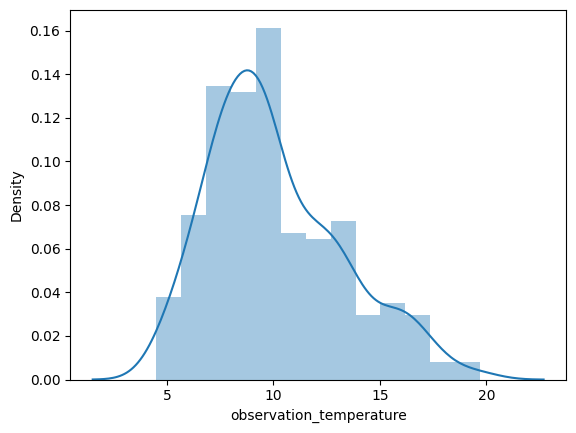

In [11]:
ax = sns.distplot(df.observation_temperature)

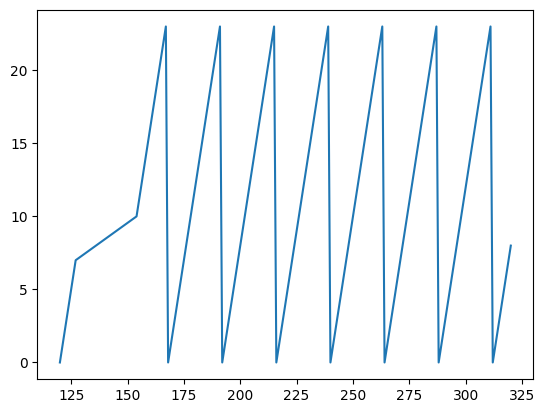

In [12]:
sample = df[:168] # roughly the first week of the data


ax = sample['hour'].plot()



In [13]:
#Adding hour as cyclic features

df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24.0)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24.0)



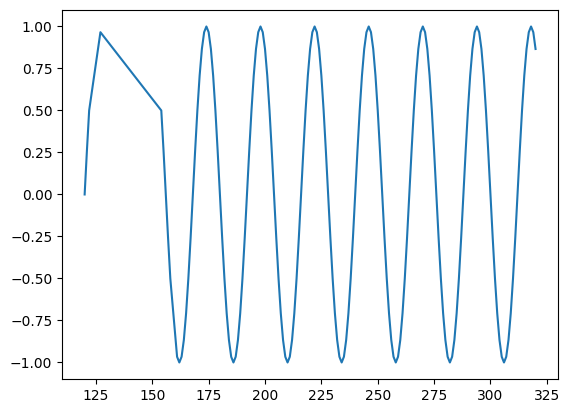

In [14]:
sample = df[0:168]
ax = sample['hour_sin'].plot()

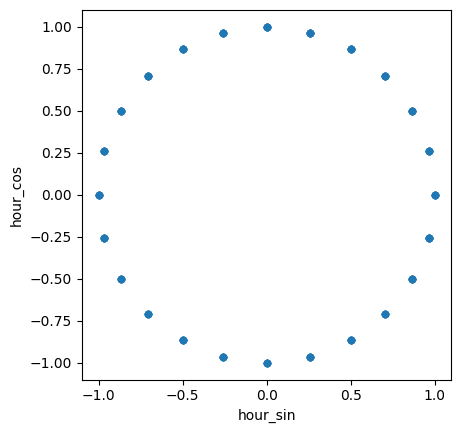

In [15]:
#Showing hour turning into a cyclic feature 

ax = sample.plot.scatter('hour_sin', 'hour_cos').set_aspect('equal')



In [16]:
#Defining Function for turning features into cyclic 
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [17]:


# df['month'] = df.datetime.dt.month
df = encode(df, 'month', 12)

# df['day'] = df.datetime.dt.day
# df = encode(df, 'day', 31)
df = encode(df, 'day of week', 7)
df = encode(df, 'day of month', 31)




In [18]:
# df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318 entries, 120 to 477
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   time                               318 non-null    object 
 1   Comms and Services                 318 non-null    float64
 2   Car Chargers                       318 non-null    float64
 3   Space Heating                      318 non-null    float64
 4   Hot Water                          318 non-null    float64
 5   Sockets                            318 non-null    float64
 6   Lighting                           318 non-null    float64
 7   total_energy                       318 non-null    object 
 8   datepart                           318 non-null    int64  
 9   weekend                            318 non-null    int64  
 10  bank holiday                       318 non-null    int64  
 11  hour                               318 non-null    int64  
 1

In [19]:
# Sum specified columns to create 'total_aob_energy'
df['total_aob_energy'] = df[['Comms and Services', 'Space Heating', 'Hot Water', 'Sockets', 'Lighting']].sum(axis=1, skipna=True)

# Drop the original columns except 'Car Chargers'
df.drop(['Comms and Services', 'Space Heating', 'Hot Water', 'Sockets', 'Lighting'], axis=1, inplace=True)

# Now, 'df' contains the new 'total_aob_energy' column and has the specified columns dropped, except 'Car Chargers'

In [20]:
# Group the data by 'hour' and calculate the average energy consumption for each hour
average_consumption_per_hour = df.groupby('hour')['total_aob_energy'].mean().reset_index()

# Sort the results by energy consumption in descending order to find the hours with the most consumption
sorted_average_consumption = average_consumption_per_hour.sort_values(by='total_aob_energy', ascending=False)

# Display the sorted average consumption
# print(sorted_average_consumption)
print(sorted_average_consumption.to_string(index=False))

 hour  total_aob_energy
    9          4.504829
    8          4.432438
    7          4.431457
    5          4.357174
    6          4.255505
    4          4.200445
    3          3.901585
   10          3.632860
   12          3.518844
   11          3.365157
   16          2.958968
   15          2.935504
   14          2.891866
   13          2.657908
    2          2.636955
   17          2.107647
   18          1.945274
    0          1.791213
   19          1.740725
    1          1.714266
   22          1.700204
   23          1.691735
   21          1.648049
   20          1.635785


### The increase in energy consumption observed in the dataset can be attributed to the activation of the building's heating system at 3 AM. This early activation is strategically planned to ensure that the building reaches a comfortable temperature by the beginning of working hours. Such a practice is common in building management to enhance comfort levels for occupants upon their arrival, but it also significantly impacts overall energy usage, highlighting the balance between energy efficiency and occupant comfort in building operations.

In [21]:
# Split data into features and target
X = df.drop(['time','forecast_datadate','forecastperiod','total_energy', 'total_aob_energy','forecast_winddirection','observation_winddirection','forecast_visibility','forecast_interval','observationperiod'], axis=1)  # Assuming 'energy_consumption' is the target variable
y = df['total_aob_energy']
# X = df[['hour_sin','hour_cos','Car Chargers','forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# X = df[['forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Model Training
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

#gradient-boosted regression model
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)

#Ridge Model 
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

#Lasso Model
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

#Support Vector Regression 
svr_model = SVR()
svr_model.fit(X_train, y_train)

# Model Evaluation
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_gbr = gbr_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_svr = svr_model.predict(X_test)

#https://stats.stackexchange.com/questions/255276/normalized-root-mean-square-error-nrmse-with-zero-mean-of-observed-value
# Calculate range of the target variable
y_range = np.max(y_test) - np.min(y_test)
# Calculate the mean of the target variable
y_mean = np.mean(y_test)
# Calculate RMSE for Linear Regression
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
# Calculate Normalised RMSE for Linear Regression
lr_nrmse = lr_rmse / y_range
# Calculate rRMSE (relative RMSE) for Linear Regression, normalized by the mean of y_test
lr_rrmse = lr_rmse / y_mean
# Calculate MAE
lr_mae = np.mean(np.abs(y_test - y_pred_lr))
print("Mean Absolute Error (MAE) for Linear Regression:", lr_mae)
# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
lr_mape = np.mean(np.abs((y_test - y_pred_lr) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Linear Regression:", lr_mape, "%")

print("Linear Regression RMSE:", lr_rmse)
print("Linear Regression NRMSE:", lr_nrmse)
print("Linear Regression rRMSE:", lr_rrmse)



# Calculate normalised RMSE for Random Forest
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
# Calculate Normalised RMSE for Random Forest
rf_nrmse = rf_rmse / y_range
# Calculate rRMSE (relative RMSE) for Random Forest, normalised by the mean of y_test
rf_rrmse = rf_rmse / y_mean
# Calculate MAE
rf_mae = np.mean(np.abs(y_test - y_pred_rf))
print("Mean Absolute Error (MAE) for Random Forest:", rf_mae)
# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
rf_mape = np.mean(np.abs((y_test - y_pred_rf) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Random Forest:", rf_mape, "%")
print("Random Forest RMSE:", rf_rmse)
print("Random Forest NRMSE:", rf_nrmse)
print("Random Forest rRMSE:", rf_rrmse)



# Calculate nomrlaised RMSE for Gradient-boosted Regression
gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
# Calculate Normalised RMSE for Gradient-boosted regression
gbr_nrmse = gbr_rmse / y_range
# Calculate rRMSE (relative RMSE) for Gradient boosting, normalised by the mean of y_test
gbr_rrmse = gbr_rmse / y_mean
# Calculate MAE
gbr_mae = np.mean(np.abs(y_test - y_pred_gbr))
print("Mean Absolute Error (MAE) for Gradient Boosting Regression:", gbr_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
gbr_mape = np.mean(np.abs((y_test - y_pred_gbr) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Gradient Boosting Regression:", gbr_mape, "%")
print("Gradient Boosting Regression RMSE:", gbr_rmse)
print("Gradient Boosting Regression NRMSE:", gbr_nrmse)
print("Gradient Boosting Regression rRMSE:", gbr_rrmse)

# Calculate nomrlaised RMSE for Ridge
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
# Calculate Normalised RMSE for Ridge regression
ridge_nrmse = ridge_rmse / y_range
# Calculate rRMSE (relative RMSE) for Ridge, normalised by the mean of y_test
ridge_rrmse = ridge_rmse / y_mean
# Calculate MAE
ridge_mae = np.mean(np.abs(y_test - y_pred_ridge))
print("Mean Absolute Error (MAE) for Ridge:", ridge_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
ridge_mape = np.mean(np.abs((y_test - y_pred_ridge) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Ridge:", ridge_mape, "%")
print("Ridge RMSE:", ridge_rmse)
print("Ridge NRMSE:", ridge_nrmse)
print("Ridge rRMSE:", ridge_rrmse)



# Calculate nomrlaised RMSE for Lasso
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
# Calculate Normalised RMSE for Lasso regression
lasso_nrmse = lasso_rmse / y_range
# Calculate rRMSE (relative RMSE) for Lasso, normalised by the mean of y_test
lasso_rrmse = lasso_rmse / y_mean
# Calculate MAE
lasso_mae = np.mean(np.abs(y_test - y_pred_lasso))
print("Mean Absolute Error (MAE) for Lasso:", lasso_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
lasso_mape = np.mean(np.abs((y_test - y_pred_lasso) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Lasso:", lasso_mape, "%")
print("Lasso RMSE:", lasso_rmse)
print("Lasso NRMSE:", lasso_nrmse)
print("Lasso rRMSE:", lasso_rrmse)

# Calculate nomrlaised RMSE for support vector regression
svr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svr))
# Calculate Normalised RMSE for support vector regression regression
svr_nrmse = svr_rmse / y_range
# Calculate rRMSE (relative RMSE) for support vector regression, normalised by the mean of y_test
svr_rrmse = svr_rmse / y_mean
# Calculate MAE
svr_mae = np.mean(np.abs(y_test - y_pred_svr))
print("Mean Absolute Error (MAE) for SVR:", svr_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
svr_mape = np.mean(np.abs((y_test - y_pred_svr) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for SVR:", svr_mape, "%")
print("SVR RMSE:", svr_rmse)
print("SVR NRMSE:", svr_nrmse)
print("SVR rRMSE:", svr_rrmse)





Mean Absolute Error (MAE) for Linear Regression: 1.1478173743420412
Mean Absolute Percentage Error (MAPE) for Linear Regression: 68.79899655663687 %
Linear Regression RMSE: 1.4645956657861456
Linear Regression NRMSE: 0.3416369404197223
Linear Regression rRMSE: 0.6841089629820977
Mean Absolute Error (MAE) for Random Forest: 1.0204511076704685
Mean Absolute Percentage Error (MAPE) for Random Forest: 70.28973192965105 %
Random Forest RMSE: 1.3094259975278115
Random Forest NRMSE: 0.3054414962107121
Random Forest rRMSE: 0.611629600030067
Mean Absolute Error (MAE) for Gradient Boosting Regression: 1.1839356271584331
Mean Absolute Percentage Error (MAPE) for Gradient Boosting Regression: 79.84948002407042 %
Gradient Boosting Regression RMSE: 1.5142556496281372
Gradient Boosting Regression NRMSE: 0.353220809836654
Gradient Boosting Regression rRMSE: 0.7073050169111643
Mean Absolute Error (MAE) for Ridge: 1.2398435982506122
Mean Absolute Percentage Error (MAPE) for Ridge: 73.52312148829006 %
Ri

In [22]:
# Define models in a dictionary
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting Regression": GradientBoostingRegressor(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "SVR": SVR()
}

# Fit models and make predictions
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

# Evaluate models
for name, y_pred in predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name} RMSE: {rmse:.2f}")

Linear Regression RMSE: 1.46
Random Forest RMSE: 1.36
Gradient Boosting Regression RMSE: 1.51
Ridge RMSE: 1.67
Lasso RMSE: 1.55
SVR RMSE: 1.11


The relative Root Mean Squared Error (rRMSE) is another variation of the RMSE metric used to assess the performance of regression models, providing a measure relative to the observed data's variability or range. While the normalised RMSE (NRMSE) is normalised by the range of the target variable, as shown in the previous example, the rRMSE typically refers to normalisation by the mean of the target variable. However, terminology can sometimes vary between fields or sources, so it's important to clarify the context when discussing "relative" or "normalised" errors.

In [23]:

# Get the current date and time
current_timestamp = datetime.now()

# Format the timestamp without seconds
formatted_timestamp = current_timestamp.strftime('%Y-%m-%d %H:%M')

print("Formatted Timestamp:", formatted_timestamp)

Formatted Timestamp: 2024-03-19 20:38


In [24]:
# Assuming y_test, y_pred_lr, y_pred_rf, y_pred_gbr, y_pred_ridge, y_pred_lasso, y_pred_svr are defined
# Define a dictionary to hold the results
results = {
    "Method": [],
    "RMSE": [],
    "NRMSE": [],
    "rRMSE": [],
    "MAE": [],
    "MAPE": []
}

methods = ["Linear Regression", "Random Forest", "Gradient Boosting Regression", "Ridge", "Lasso", "SVR"]
predictions = [y_pred_lr, y_pred_rf, y_pred_gbr, y_pred_ridge, y_pred_lasso, y_pred_svr]

y_range = np.max(y_test) - np.min(y_test)
y_mean = np.mean(y_test)
i = 0
for method, y_pred in zip(methods, predictions):
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # Calculate NRMSE
    nrmse = rmse / y_range
    # Calculate rRMSE
    rrmse = rmse / y_mean
    # Calculate MAE
    mae = np.mean(np.abs(y_test - y_pred))
    # Calculate MAPE
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100

    # Append the results
    results["Method"].append(method)
    results["RMSE"].append(rmse)
    results["NRMSE"].append(nrmse)
    results["rRMSE"].append(rrmse)
    results["MAE"].append(mae)
    results["MAPE"].append(mape)

# Convert the dictionary to a pandas DataFrame
results_df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
name = f"regression_metrics_AOBresults{formatted_timestamp}.csv"
results_df.to_csv(name, index=False)

print("Results saved to ",name)

Results saved to  regression_metrics_AOBresults2024-03-19 20:38.csv


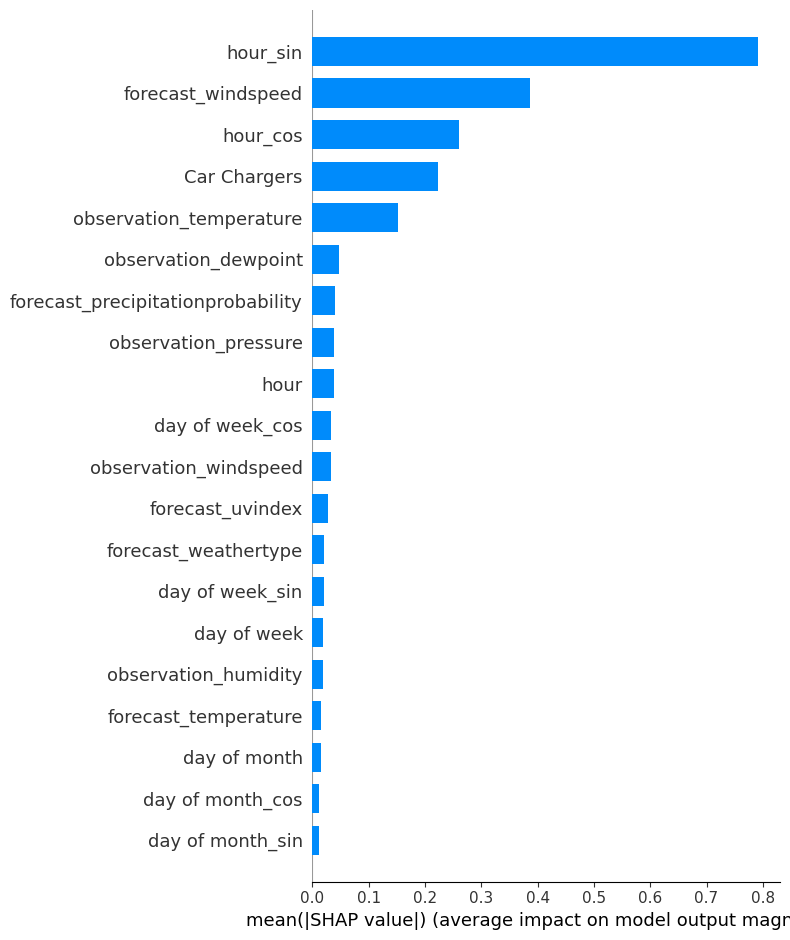

In [25]:
# Feature Importance Analysis with SHAP for Random Forest
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar", title = 'Shaply value for Random forest model for predicting indoor energy consumption')

# Replace the model training and evaluation code with your model of choice and adjust the feature engineering 
# and data preparation steps based on your dataset specifics.

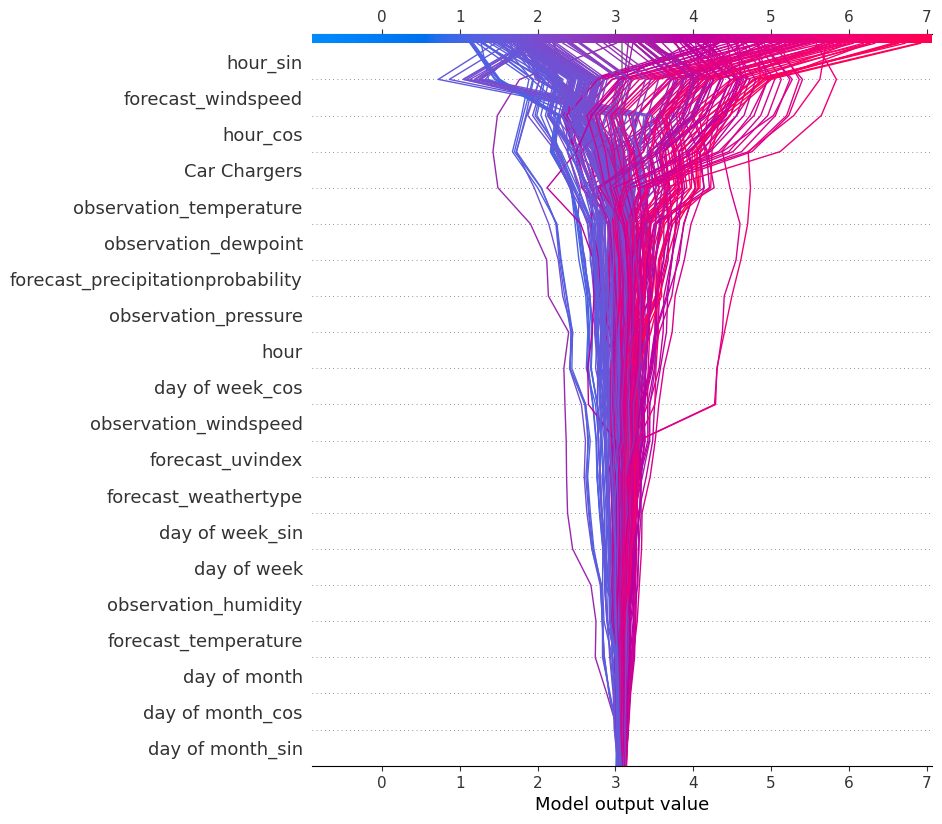

In [26]:
feature_names = X_train.columns.tolist()
shap.decision_plot(explainer.expected_value, shap_values, feature_names = feature_names)


In [27]:
print(X_train.shape)

(254, 28)


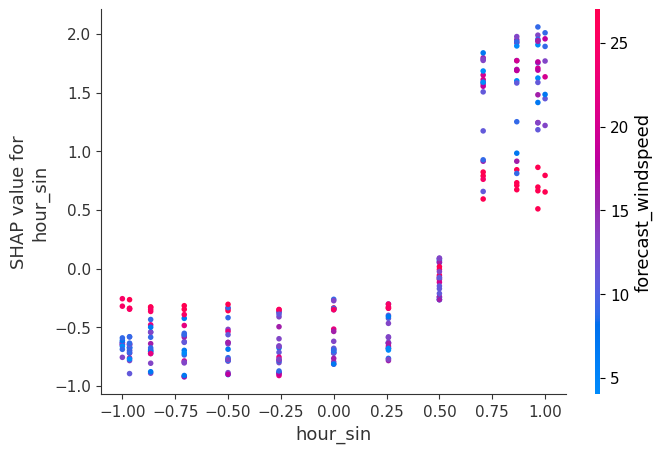

In [28]:
shap.dependence_plot(ind ='hour_sin', shap_values = shap_values, features = X_train, feature_names = feature_names)

In [29]:
# shap.partial_dependence_plot(ind = 'hour_sin', model = rf_model , data = X_train, feature_names = feature_names)

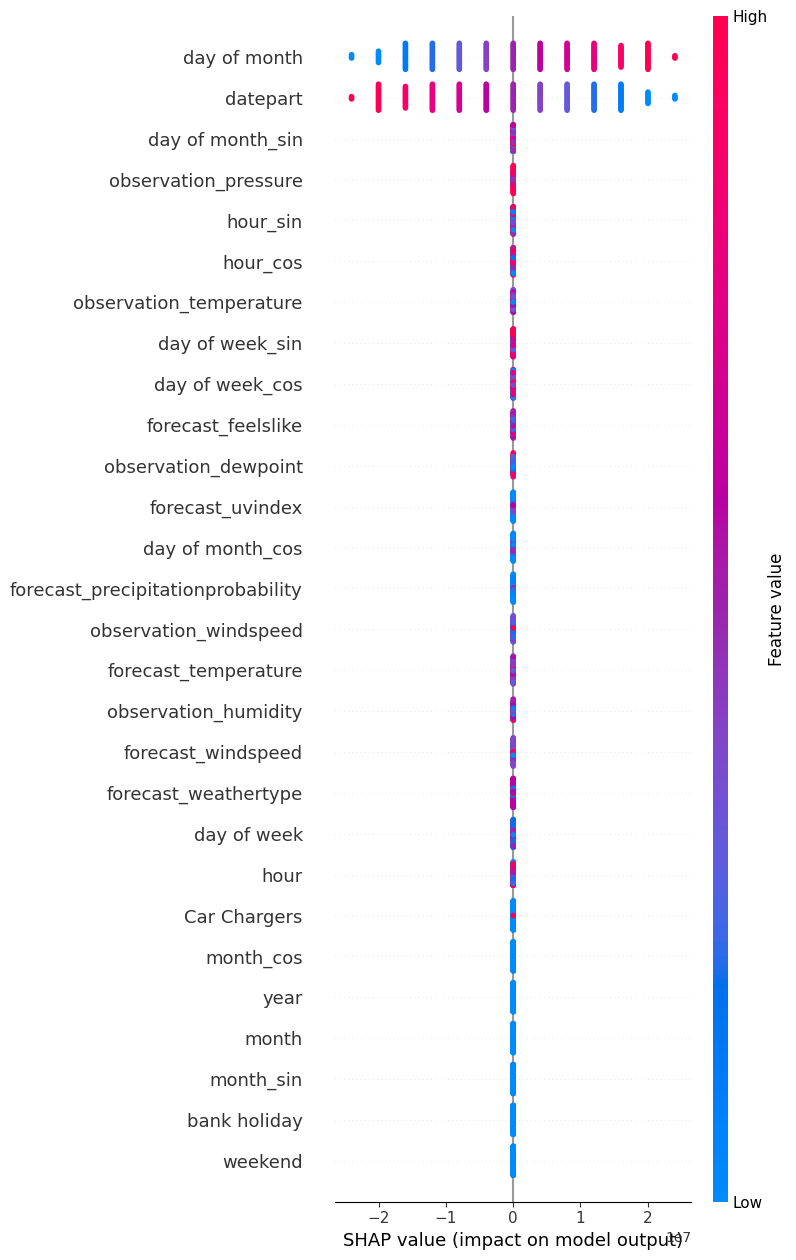

<Figure size 640x480 with 0 Axes>

In [30]:
# Initialize the explainer
explainer = shap.LinearExplainer(lr_model, X_train)

# Compute SHAP values
shap_values = explainer.shap_values(X_train)
# Summary plot
shap.summary_plot(shap_values, X_train, max_display = len(X_train))

plt.suptitle('SHAP Value for Indoor Electricity Usage Linear Regression Predictor', fontsize=14, fontweight='bold')

plt.show()
# # Use plt.gcf() to get the current figure and then set the title
# plt.gcf().suptitle('SHAP Value for Indoor Electricity Usage Linear Regression Predictor', fontsize=14, fontweight='bold')



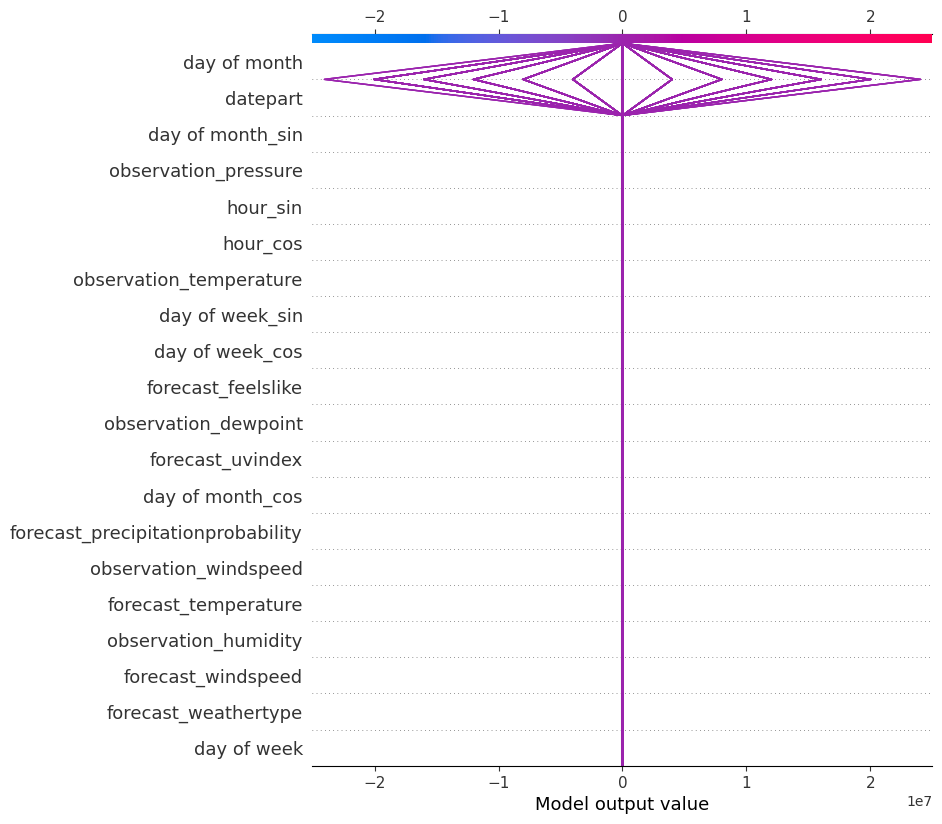

In [31]:
feature_names = X_train.columns.tolist()
shap.decision_plot(explainer.expected_value, shap_values, feature_names = feature_names)


In [32]:
# Get the current date and time
current_timestamp = datetime.now()
# Format the timestamp without seconds
formatted_timestamp = current_timestamp.strftime('%Y-%m-%d %H:%M')

Linear Regression RMSE: 3.072858955542813
Linear Regression NRMSE: 0.21662064736742265
Random Forest RMSE: 3.201411515839641
Random Forest NRMSE: 0.22568293731796135
Gradient Boosting Regression RMSE: 4.355494339634842
Gradient Boosting Regression NRMSE: 0.3070398014054567
Ridge RMSE: 3.061039383525699
Ridge NRMSE: 0.21578742873324655
Lasso RMSE: 3.2174839791807153
Lasso NRMSE: 0.2268159627721406
SVR RMSE: 3.481209158137757
SVR NRMSE: 0.24540722251405486


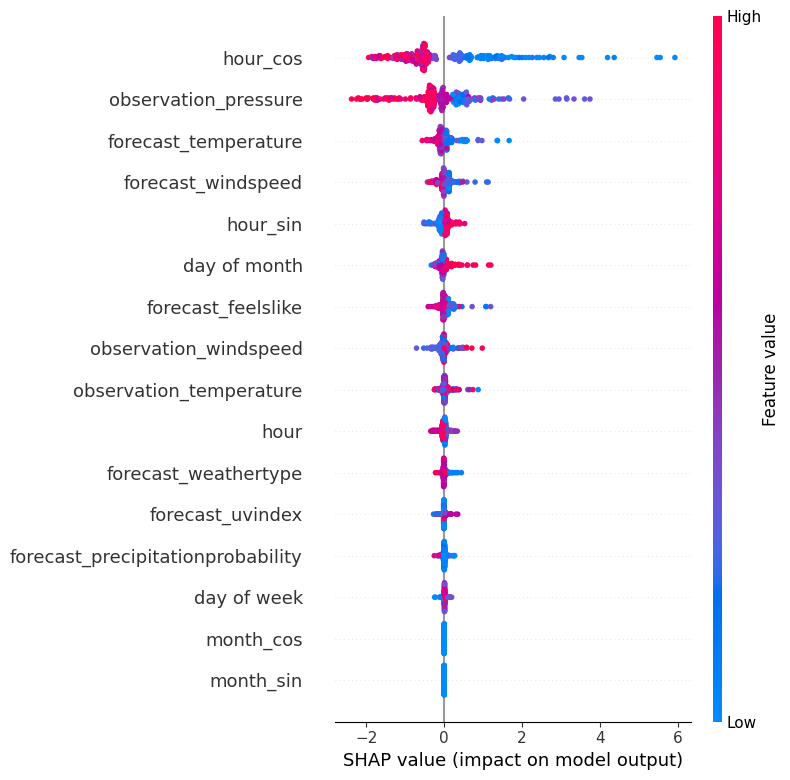

In [33]:
# Split data into features and target
# X = df.drop(['total_energy'], axis=1)  # Assuming 'energy_consumption' is the target variable
y = df['Car Chargers']
X = df[['hour_sin','hour_cos','forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

#gradient-boosted regression model
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)

#Ridge Model 
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

#Lasso Model
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

#Support Vector Regression 
svr_model = SVR()
svr_model.fit(X_train, y_train)

# Model Evaluation
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_gbr = gbr_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_svr = svr_model.predict(X_test)

# print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
# print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
#https://stats.stackexchange.com/questions/255276/normalized-root-mean-square-error-nrmse-with-zero-mean-of-observed-value
y_range = np.max(y_test) - np.min(y_test)
# Calculate normalsied RMSE for Linear Regression
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
# Calculate range of the target variable
# Calculate Normalized RMSE for Linear Regression
lr_nrmse = lr_rmse / y_range
print("Linear Regression RMSE:", lr_rmse)
print("Linear Regression NRMSE:", lr_nrmse)



# Calculate normalised RMSE for Random Forest
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
# Calculate Normalizsd RMSE for Random Forest
rf_nrmse = rf_rmse / y_range
print("Random Forest RMSE:", rf_rmse)
print("Random Forest NRMSE:", rf_nrmse)



# Calculate nomrlaised RMSE for Gradient-boosted Regression
gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
# Calculate Normalizsd RMSE for Gradient-boosted regression
gbr_nrmse = gbr_rmse / y_range
print("Gradient Boosting Regression RMSE:", gbr_rmse)
print("Gradient Boosting Regression NRMSE:", gbr_nrmse)

# Calculate nomrlaised RMSE for Ridge
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
# Calculate Normalizsd RMSE for Gradient-boosted regression
ridge_nrmse = ridge_rmse / y_range
print("Ridge RMSE:", ridge_rmse)
print("Ridge NRMSE:", ridge_nrmse)



# Calculate nomrlaised RMSE for Lasso
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
# Calculate Normalizsd RMSE for Gradient-boosted regression
lasso_nrmse = lasso_rmse / y_range
print("Lasso RMSE:", lasso_rmse)
print("Lasso NRMSE:", lasso_nrmse)

# Calculate nomrlaised RMSE for support vector regression
svr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svr))
# Calculate Normalizsd RMSE for Gradient-boosted regression
svr_nrmse = svr_rmse / y_range
print("SVR RMSE:", svr_rmse)
print("SVR NRMSE:", svr_nrmse)

# Feature Importance Analysis with SHAP for Random Forest
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

# Replace the model training and evaluation code with your model of choice and adjust the feature engineering 
# and data preparation steps based on your dataset specifics.

In [34]:
# Assuming y_test, y_pred_lr, y_pred_rf, y_pred_gbr, y_pred_ridge, y_pred_lasso, y_pred_svr are defined
# Define a dictionary to hold the results
results = {
    "Method": [],
    "RMSE": [],
    "NRMSE": [],
    "rRMSE": [],
    "MAE": [],
    "MAPE": []
}

methods = ["Linear Regression", "Random Forest", "Gradient Boosting Regression", "Ridge", "Lasso", "SVR"]
predictions = [y_pred_lr, y_pred_rf, y_pred_gbr, y_pred_ridge, y_pred_lasso, y_pred_svr]

y_range = np.max(y_test) - np.min(y_test)
y_mean = np.mean(y_test)

for method, y_pred in zip(methods, predictions):
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # Calculate NRMSE
    nrmse = rmse / y_range
    # Calculate rRMSE
    rrmse = rmse / y_mean
    # Calculate MAE
    mae = np.mean(np.abs(y_test - y_pred))
    # Calculate MAPE
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100

    # Append the results
    results["Method"].append(method)
    results["RMSE"].append(rmse)
    results["NRMSE"].append(nrmse)
    results["rRMSE"].append(rrmse)
    results["MAE"].append(mae)
    results["MAPE"].append(mape)

# Convert the dictionary to a pandas DataFrame
results_df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
name = f"regression_metrics_CarChargersResults{formatted_timestamp}.csv"
results_df.to_csv(name, index=False)

print("Results saved to ",name)

Results saved to  regression_metrics_CarChargersResults2024-03-19 20:38.csv


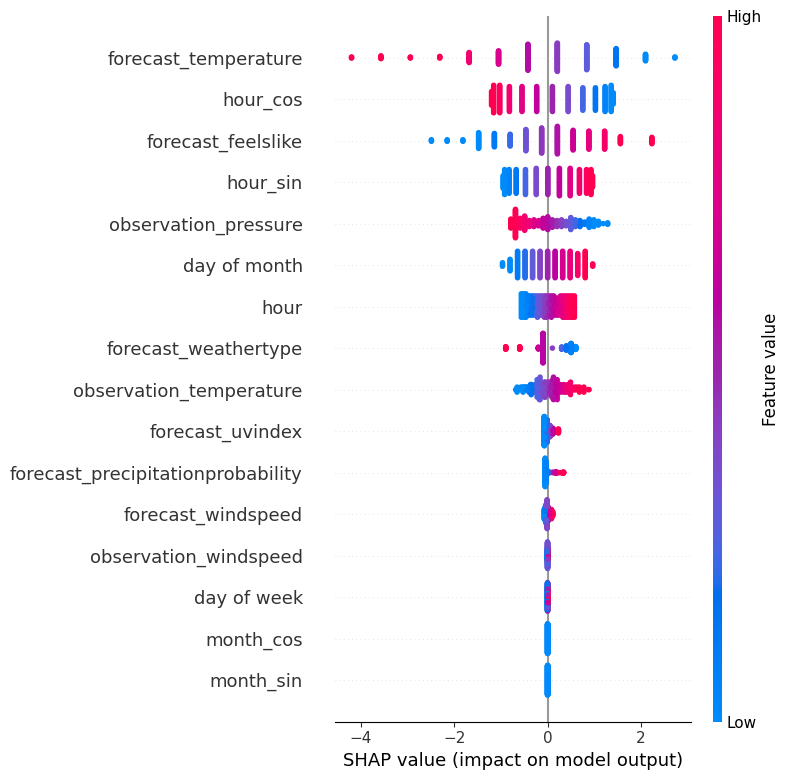

In [35]:
# Assuming 'model' is your trained linear regression model
# and 'X_train' is your training dataset

# Initialize the explainer
explainer = shap.LinearExplainer(lr_model, X_train)

# Compute SHAP values
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train)#, plot_type="bar")

In [36]:
# Define your future time range
future_dates = pd.date_range(start='2024-01-01', end='2024-01-31', freq='H')  # Example for January 2024

# Create a DataFrame
future_df = pd.DataFrame(future_dates, columns=['date'])
future_df['hour'] = future_df['date'].dt.hour
future_df['month'] = future_df['date'].dt.month
future_df['year'] = future_df['date'].dt.year


# Add additional features as needed, e.g., weather predictions
# future_df[]
# future_df['temperature'] = ...


In [37]:
# # Add missing columns with placeholder or estimated values
# required_columns = ['forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','hour' , 'day of week','day of month' ,'month','year']
# for col in required_columns:
#     if col not in future_df.columns:
#         future_df[col] = 0  # Or use a more appropriate placeholder/estimation method

# # Ensure column order matches the training data
# # Assuming 'train_columns' is a list of column names in the order they were in during training
# future_df = future_df[required_columns]

# # Retry prediction
# predictions = lr_model.predict(future_df)

# # Add predictions back to your DataFrame
# # future_df['total_energy'] = predictions

# # Create model_future_df from future_df
# lrmodel_future_df = future_df.copy()

# # Add the 'total_energy' column from predictions
# lrmodel_future_df['total_energy'] = predictions

In [38]:
# from sklearn.linear_model import Ridge

# # Initialize the model
# ridge_model = Ridge()

# # Fit the model
# ridge_model.fit(X_train, y_train)
# predictions_ridge0 = ridge_model.predict(X_test)

# # Add predictions back to your DataFrame
# # future_df['total_energy'] = predictions
# print("Ridge Regression RMSE:", np.sqrt(mean_squared_error(y_test, predictions_ridge0)))

# # Predict on future data
# predictions_ridge = ridge_model.predict(future_df)

# ridgemodel_future_df = future_df.copy()

# # # Add the 'total_energy' column from predictions
# ridgemodel_future_df['total_energy'] = predictions_ridge


In [39]:
# from sklearn.linear_model import Lasso

# # Initialize the model
# lasso_model = Lasso()

# # Fit the model
# lasso_model.fit(X_train, y_train)
# predictions_lasso0 = lasso_model.predict(X_test)

# # Add predictions back to your DataFrame
# # future_df['total_energy'] = predictions
# print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, predictions_lasso0)))

# # Predict on future data
# predictions_lasso = lasso_model.predict(future_df)

# lassomodel_future_df = future_df.copy()

# # # Add the 'total_energy' column from predictions
# lassomodel_future_df['total_energy'] = predictions_lasso



In [40]:
import time

# Get the current Unix timestamp
unix_timestamp = time.time()

print("Unix Timestamp:", unix_timestamp)

Unix Timestamp: 1710880708.323999


In [41]:
# # Assuming 'model' is your trained regression model
# predictions = lr_model.predict(future_df.drop('date', axis=1))  # Drop 'date' if it's not used directly by your model

# # Add predictions back to your DataFrame
# future_df['predicted_energy_consumption'] = predictions


In [42]:
# # df =  df.drop(['time'], axis =1)
# y = df['total_aob_energy']
# X = df[['hour_sin','hour_cos','forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# # Split the data into training and testing sets
# # display(df)
# # print(df.columns)

In [43]:
X_train.dropna(inplace = True)
display(X_train)
X_train.info()

,hour_sin,hour_cos,forecast_temperature,forecast_feelslike,forecast_weathertype,forecast_precipitationprobability,forecast_windspeed,forecast_uvindex,observation_temperature,observation_windspeed,observation_pressure,hour,day of week,day of month,month_sin,month_cos
120,0.000000,1.000000,8.0,6.0,7.0,3.0,11.0,0.0,8.5,13.0,1006.0,0,6,6,0.866025,-0.5
121,0.258819,0.965926,8.0,6.0,7.0,3.0,11.0,0.0,8.3,11.0,1006.0,1,6,6,0.866025,-0.5
122,0.500000,0.866025,8.0,6.0,7.0,3.0,11.0,0.0,7.8,13.0,1006.0,2,6,6,0.866025,-0.5
127,0.965926,-0.258819,8.0,4.0,7.0,4.0,13.0,1.0,8.8,14.0,1007.0,7,6,6,0.866025,-0.5
154,0.500000,-0.866025,10.0,8.0,7.0,9.0,11.0,2.0,11.2,16.0,1008.0,10,0,7,0.866025,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,-0.500000,0.866025,14.0,11.0,2.0,1.0,13.0,0.0,12.5,9.0,1019.0,22,3,17,0.866025,-0.5
407,-0.258819,0.965926,14.0,11.0,2.0,1.0,13.0,0.0,11.8,15.0,1020.0,23,3,17,0.866025,-0.5
408,0.000000,1.000000,12.0,10.0,0.0,0.0,9.0,0.0,14.4,13.0,1026.0,0,4,18,0.866025,-0.5
409,0.258819,0.965926,12.0,10.0,7.0,3.0,11.0,0.0,14.3,13.0,1026.0,1,4,18,0.866025,-0.5


<class 'pandas.core.frame.DataFrame'>
Index: 254 entries, 120 to 410
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   hour_sin                           254 non-null    float64
 1   hour_cos                           254 non-null    float64
 2   forecast_temperature               254 non-null    float64
 3   forecast_feelslike                 254 non-null    float64
 4   forecast_weathertype               254 non-null    float64
 5   forecast_precipitationprobability  254 non-null    float64
 6   forecast_windspeed                 254 non-null    float64
 7   forecast_uvindex                   254 non-null    float64
 8   observation_temperature            254 non-null    float64
 9   observation_windspeed              254 non-null    float64
 10  observation_pressure               254 non-null    float64
 11  hour                               254 non-null    int64  
 1

In [44]:
df =  df.drop(['time','total_energy','forecast_datadate','forecastperiod','forecast_winddirection','forecast_visibility','forecast_interval','observationperiod','observation_winddirection'], axis = 1)
df.dropna(inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318 entries, 120 to 477
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Car Chargers                       318 non-null    float64
 1   datepart                           318 non-null    int64  
 2   weekend                            318 non-null    int64  
 3   bank holiday                       318 non-null    int64  
 4   hour                               318 non-null    int64  
 5   day of week                        318 non-null    int64  
 6   day of month                       318 non-null    int64  
 7   month                              318 non-null    int64  
 8   year                               318 non-null    int64  
 9   forecast_temperature               318 non-null    float64
 10  forecast_feelslike                 318 non-null    float64
 11  forecast_weathertype               318 non-null    float64
 1

It’s worth noting that a regression problem can be converted into a classification problem by simply discretizing the response variable into buckets.

In [45]:

# Assuming df is your DataFrame with the time series data
# The target column should be the last column if you're planning to predict it

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        # find the end of the current sequence
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix, :-1], data[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Number of time steps you want to consider for each sample
n_steps = 24  # For example, using 24 hours of data to predict the next hour
# df = df.drop(['total_energy', 'forecast_datadate','forecastperiod','forecastperiod','forecast_visibility','forecast_interval','observationperiod','observation_winddirection'], axis=1)
# Convert the DataFrame to numpy array for processing
data = df.to_numpy()
# data_converted = np.array([[[float(item) if isinstance(item, str) and item.replace('.', '', 1).isdigit() else item for item in sublist] for sublist in outerlist] for outerlist in data])
# df.info()

# Create sequences using the defined function
X, y = create_sequences(data, n_steps)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# You can then split X and y into training and test sets as needed


Shape of X: (294, 24, 28)
Shape of y: (294,)


In [46]:
# # Assuming df is your DataFrame with the time series data
# # The target column should be the last column if you're planning to predict it

# def create_sequences(data, n_steps):
#     X, y = [], []
#     for i in range(len(data)):
#         # find the end of the current sequence
#         end_ix = i + n_steps
#         # check if we are beyond the dataset
#         if end_ix > len(data)-1:
#             break
#         # gather input and output parts of the pattern
#         seq_x, seq_y = data[i:end_ix, :-1], data[end_ix, -1]
#         X.append(seq_x)
#         y.append(seq_y)
#     return np.array(X), np.array(y)

# # Example DataFrame conversion, replace with your actual DataFrame loading/conversion
# # df = pd.read_csv('your_data.csv')

# # Number of time steps you want to consider for each sample
# n_steps = 24  # For example, using 24 hours of data to predict the next hour

# # Convert the DataFrame to numpy array for processing, applying conversion where necessary
# data = np.array([[float(item) if isinstance(item, str) and item.replace('.', '', 1).isdigit() else item for item in row] for row in df.to_numpy()])

# # Create sequences using the defined function
# X, y = create_sequences(data, n_steps)

# print(f"Shape of X: {X.shape}")
# print(f"Shape of y: {y.shape}")

# # You can then split X and y into training and test sets as needed


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_test.dtype
X_test

array([[[ 4.80513611e+00,  4.35720000e+04,  0.00000000e+00, ...,
         -9.00968868e-01, -2.99363123e-01, -9.54139256e-01],
        [ 7.93999167e+00,  4.35720000e+04,  0.00000000e+00, ...,
         -9.00968868e-01, -2.99363123e-01, -9.54139256e-01],
        [ 1.00788167e+01,  4.35720000e+04,  0.00000000e+00, ...,
         -9.00968868e-01, -2.99363123e-01, -9.54139256e-01],
        ...,
        [ 4.46472220e-02,  4.35730000e+04,  0.00000000e+00, ...,
         -9.00968868e-01, -4.85301963e-01, -8.74346616e-01],
        [ 4.46416670e-02,  4.35730000e+04,  0.00000000e+00, ...,
         -9.00968868e-01, -4.85301963e-01, -8.74346616e-01],
        [ 3.12266111e+00,  4.35730000e+04,  0.00000000e+00, ...,
         -9.00968868e-01, -4.85301963e-01, -8.74346616e-01]],

       [[ 7.93999167e+00,  4.35720000e+04,  0.00000000e+00, ...,
         -9.00968868e-01, -2.99363123e-01, -9.54139256e-01],
        [ 1.00788167e+01,  4.35720000e+04,  0.00000000e+00, ...,
         -9.00968868e-01, -2.99363123e

In [48]:
# print(X_train.dtype, y_train.dtype)  # Check data types
# # print(np.isfinite(X_train).all(), np.isfinite(y_train).all())  # Check for infinite values
# # print(np.isnan(X_train).any(), np.isnan(y_train).any())  # Check for NaN values
# # X_train  = float(X_train .replace(',','').split()[0])
# # X_train = X_train.astype(float)
# print(X_train.dtype)

In [49]:
# df = pd.read_csv("/kaggle/input/aob-sample-totalenergy/data_cut.csv") 
# # y = df['total_aob_energy']
# # X = df[['hour_sin','hour_cos','forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# # Convert all string elements to floats if they are numeric

# X_test


In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming X_train, y_train, X_test, y_test are prepared datasets
# X_train, X_test should be shaped as [samples, time_steps, features]
# For example, for 1000 samples, 10 time steps, and 5 features: X_train.shape -> (1000, 10, 5)

# Define the model architecture
model = Sequential([
    # LSTM layer for extracting temporal features (you may adjust the units and return_sequences based on your dataset)
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),  # Dropout for regularization
    
    # Additional LSTM Layer
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    
    # Dense layers for prediction - you can add or reduce the number of Dense layers
    Dense(units=25, activation='relu'),
    Dense(units=1)  # Final layer with one unit for regression output
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Model summary
model.summary()

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model.predict(X_test)

# You can further analyze the predictions, calculate metrics like MAE, RMSE, etc., and plot results.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 50)            15800     
                                                                 
 dropout (Dropout)           (None, 24, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 37301 (145.71 KB)
Trainable params: 37301 

In [51]:
#Lime